In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torch import nn

import cv2
import numpy as np
import copy
import time
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from PIL import Image
import torch.nn.functional as F
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append("../")
from utilities import helper_functions, splitting, augmentations, metrics

In [2]:
class BasicMV_AV(nn.Module):
    '''
    Pretrained model backbone, two linear layers with dropout in between.
    View feature appended after FC of pretrained network
    '''
    def __init__(self, pretrained, in_features, num_classes, visualization, dropout_1, dropout_2): 
        '''
        Initializing 2 linear layers, dropout and Leaky RelU layers
        '''
        super(BasicMV_AV, self).__init__()
        self.backbone = pretrained
        self.fc1 = nn.Linear(in_features, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout_1 = nn.Dropout(dropout_1)
        self.dropout_2 = nn.Dropout(dropout_2)
        self.activation = nn.LeakyReLU()
        self.visualization = visualization

    def forward(self, x): 
        '''
        Forward pass through network
        '''
        if self.visualization:
            a = x[:,0,0,0].float()
            b = x[:,3:,:256,:256]
            x = [b, a]
        out = self.dropout_1(self.activation(self.backbone(x[0])))
        out = torch.cat([out, x[1].view(-1,1)], dim=-1)
        out = self.activation(self.fc1(out))
        out = self.fc2(self.dropout_2(out))

        return out

In [3]:
class MultiViewDataset(Dataset):
    '''
    Brands Dataset
    '''
    
    def __init__(self, img_paths, labels, augmentation_function, png=True, visualization = False):
        '''
        Initialize the dataset
        '''
        assert len(img_paths) == len(labels), "Number of files should match number of targets"
        
        self.img_files = img_paths
        self.labels = labels
        self.augmentation_function = augmentation_function
        self.png = png
        self.visualization = visualization
    
    def load_png(self, img_path):
        '''
        This function loads an image from a PNG path
        '''
        try:
            actual_image = cv2.imread(img_path)
        except:
            print(f"Something went wrong with reading file {img_path}")
            actual_image = np.zeros((256,256)).astype(np.uint8)
        
        actual_image = Image.fromarray(actual_image)
        
        return actual_image
    
    
    def load_dicom(self, img_path):
        '''
        This function loads an image from a DICOM path
        '''
        try:
            image_info = pydicom.dcmread(img_path)
            actual_image = image_info.pixel_array
            
        except:
            print(f"Something went wrong with reading file {img_path}")
            actual_image = np.zeros((256,256))
        
        actual_image = helper_functions.prepare_image(actual_image, rgb=True, channels_first=True)
        actual_image = Image.fromarray(actual_image)

        return actual_image
    
    def handle_views(self, view):
        '''
        Function to return appropriate array based on view
        '''
        if view == "AP":
            return np.ones((1,))
        elif view == "L":
            return np.ones((1, )) + 1
    
    def __getitem__(self, index):
        '''
        Get a unique item from the dataset according to index. This is required when building a custom dataloader
        '''
        img_row = self.img_files.iloc[index,:]
        if self.png:
            X_image = self.load_png(img_row.filepath)
        else:
            X_image = self.load_dicom(img_row.filepath)
        if self.augmentation_function is not None:
            X_image = self.augmentation_function(X_image)
        X_view = self.handle_views(img_row.View)
        Y = self.labels[index]
        
        if self.visualization:
            X_view = (torch.as_tensor(X_view).repeat(X_image.shape)).float()
            concatenated = torch.cat([X_view, X_image]) 
            
            return concatenated.float(), torch.as_tensor(Y).long()
        else:
            return (X_image.float(), torch.as_tensor(X_view).float()), torch.as_tensor(Y).long()
        
    
    def __len__(self):
        '''
        Length of the dataset. This is required when building a custom dataloader
        '''
        return len(self.img_files)                

In [4]:
# Locations of final models
anterior_filepath = '../dylan/results/bmav/metrics/densenet121-dropout10.1-dropout20.2-preprocessedTrue-anterior_bestmodel.pt'
posterior_filepath = '../dylan/results/bmav/metrics/densenet121-dropout10.05-dropout20.5-preprocessedTrue-posterior_bestmodel.pt'

In [5]:
# Pretrain
pretrain = models.densenet121(pretrained=True)
# Anterior dropouts
anterior_dropout_1 = 0.1
anterior_dropout_2 = 0.2
# Posterior dropouts
posterior_dropout_1 = 0.05
posterior_dropout_2 = 0.5

In [6]:
# Loading anterior model
anterior_model = BasicMV_AV(pretrained=pretrain, in_features=1001, num_classes=4, visualization = True, 
                            dropout_1=anterior_dropout_1, dropout_2=anterior_dropout_2)
anterior_model.load_state_dict(torch.load(anterior_filepath))
anterior_model.eval()

BasicMV_AV(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [7]:
# Posterior model
posterior_model = BasicMV_AV(pretrained=pretrain, in_features=1001, num_classes=4, visualization = True,
                            dropout_1=posterior_dropout_1, dropout_2=posterior_dropout_2)
posterior_model.load_state_dict(torch.load(posterior_filepath))
posterior_model.eval()

BasicMV_AV(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum

In [8]:
# Loading anterior and posterior datasets
anterior_data = pd.read_csv("../Master_Anterior_HDW.csv")
posterior_data = pd.read_csv("../Master_Posterior_HDW.csv")

In [9]:
# Changing directories
anterior_data['filepath']  = "../" + anterior_data['filepath'].str[14:]
posterior_data['filepath']  = "../" + posterior_data['filepath'].str[14:]

In [10]:
# Using Jahangir's preprocessed images
anterior_data['filepath'] = anterior_data['filepath'].str[:-4] + "_processed.png"
posterior_data['filepath'] = posterior_data['filepath'].str[:-4] + "_processed.png"

In [11]:
print("Getting Means and Standard Deviation of Train Set...")
aug_wo_norm = augmentations.apply_augmentations_wo_norm(data_set="train", size_val=256, contrast_val=0.25, 
                                                    hue_val=0.25, grayscale_prob=0.1,
                                                    hflip_prob=0.5, degree_val=0, 
                                                    shear_val=5)
# Creating train dataset
anterior_dataset = MultiViewDataset(img_paths=anterior_data[['filepath','View']], labels=anterior_data['Label'],augmentation_function=aug_wo_norm, png=True, visualization=False)
posterior_dataset = MultiViewDataset(img_paths=posterior_data[['filepath','View']], labels=posterior_data['Label'],augmentation_function=aug_wo_norm, png=True, visualization=False)

# Getting means and stds
anterior_dataset_means, anterior_dataset_stds = helper_functions.get_training_mean_std_bmv(anterior_dataset)
posterior_dataset_means, posterior_dataset_stds = helper_functions.get_training_mean_std_bmv(posterior_dataset)
print("Finished")

Getting Means and Standard Deviation of Train Set...
Finished


In [12]:
# Setting up augmentations with normalization
param_aug = {'size_val': 256, 'contrast_val':0.25, 
             'hue_val': 0.25, 'grayscale_prob': 0.1,
             'hflip_prob': 0.5, 'degree_val':0,
             'shear_val':5
}
anterior_aug_function = augmentations.apply_augmentations_with_norm(data_set="test", 
                                                                    avg_pop_mean=anterior_dataset_means, 
                                                                    avg_pop_std=anterior_dataset_stds, **param_aug)
posterior_aug_function = augmentations.apply_augmentations_with_norm(data_set="test", 
                                                                     avg_pop_mean=posterior_dataset_means, 
                                                                     avg_pop_std=posterior_dataset_stds,
                                                                     **param_aug)

In [13]:
# Setting up final datasets
anterior_dataset = MultiViewDataset(img_paths=anterior_data[['filepath','View']], labels=anterior_data['Label'], 
                                  augmentation_function=anterior_aug_function, png=True, visualization=True)
posterior_dataset = MultiViewDataset(img_paths=posterior_data[['filepath','View']], labels=posterior_data['Label'], 
                                  augmentation_function=posterior_aug_function, png=True, visualization=True)

Label: tensor(0)


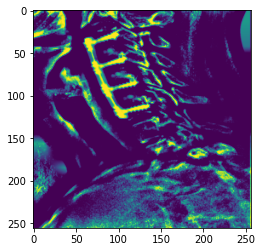

In [14]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'anterior' # or 'posterior'
img_number = 0

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()

In [15]:
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
elif dataset == 'posterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))

Output Logits: tensor([[ 1.4817,  0.3612, -0.3956, -0.9955]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[0.6398, 0.2086, 0.0979, 0.0537]], grad_fn=<SoftmaxBackward>)
Output Label: tensor(0)


## ANTERIOR - ATLANTIS BRAND 0 (True Positive)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed, target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[0]]) ( 0.6397669911384583 )


torch.Size([3, 1, 256, 256])


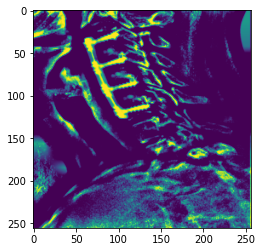

In [17]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())

### Gradient-based attribution

Attributions are calculated using Integrated Gradients which are calculates the integral of output gradients for the predicted class with respect to the input image.

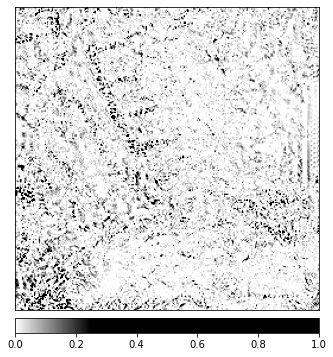

In [37]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Attributions are calculated using Integrated Gradients and smoothened across multiple images via a noise tunnel by adding gaussian noise with a std = 1, n_samples time to the input.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


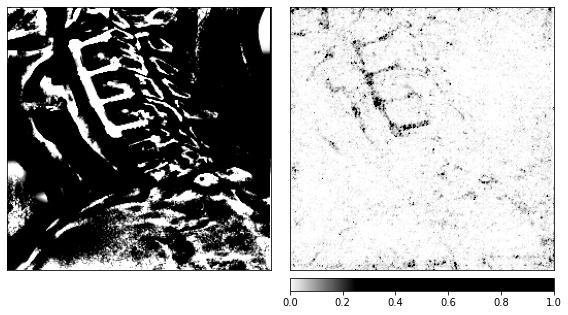

In [21]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

GradientShap is a linear explanation model which uses a distribution of reference samples to explain model predictions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


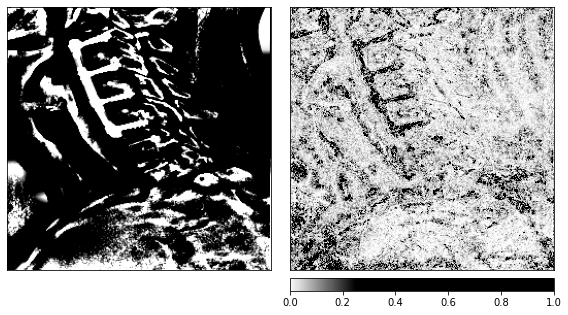

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Critical areas are identified by occluding them and quantifying how decision changes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


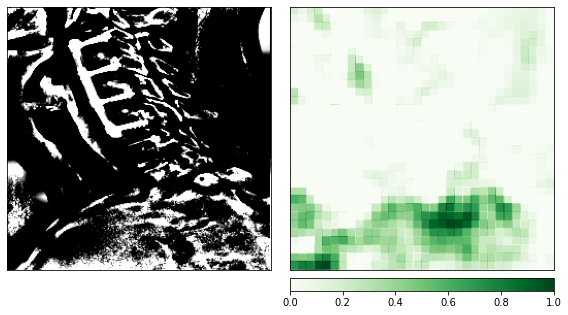

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


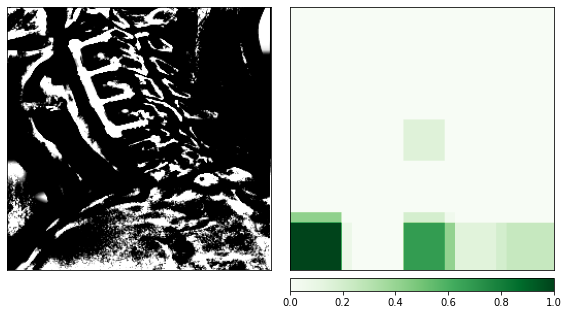

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## ANTERIOR - ARCHON BRAND 1 (True Positive)

Label: tensor(1)


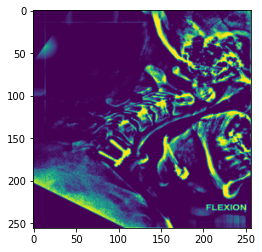

In [154]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'anterior' # or 'posterior'
img_number = 334

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model.to(device)
    model_ft.eval()
    output = model_ft(data_to_feed.to(device))
elif dataset == 'posterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))

Output Logits: tensor([[ 0.8028,  0.8173, -0.6178, -0.1641]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[0.3793, 0.3848, 0.0916, 0.1442]], grad_fn=<SoftmaxBackward>)
Output Label: tensor(1)


In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device='cpu'
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed.to(device), target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[1]]) ( 0.3848344087600708 )
True Label:  tensor(1)


torch.Size([3, 1, 256, 256])


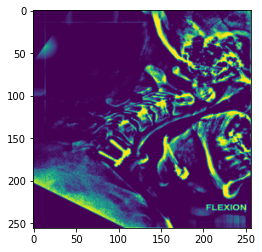

In [157]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())

### Gradient-based attribution

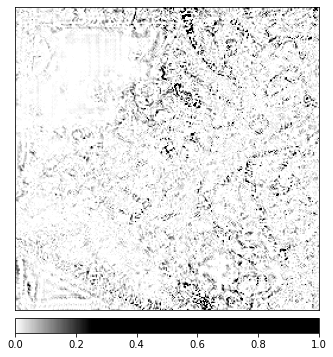

In [159]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


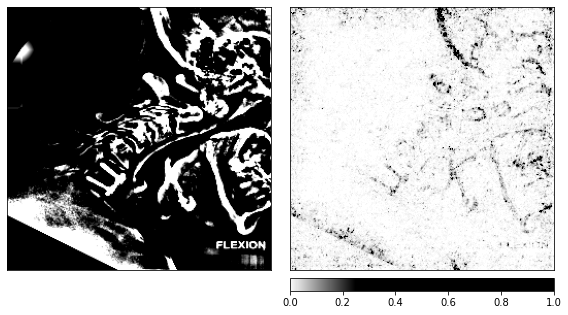

In [160]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


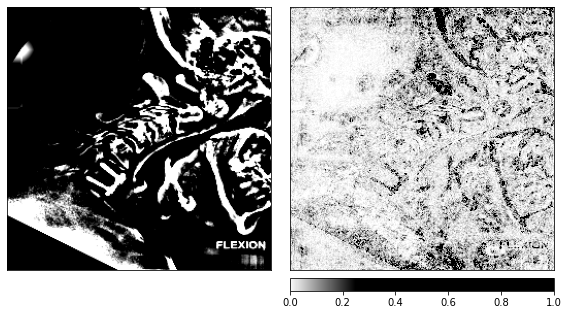

In [161]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


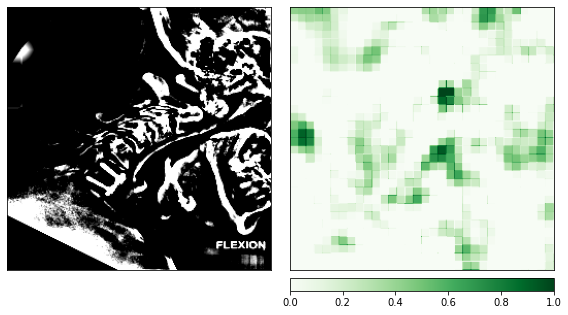

In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


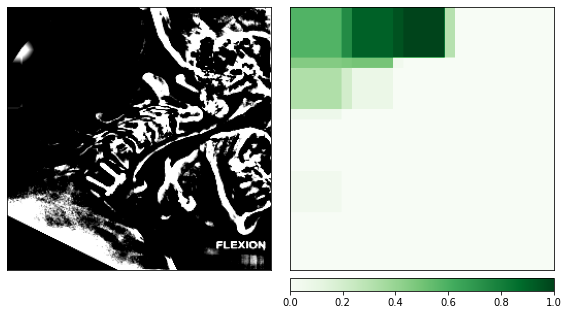

In [163]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## ANTERIOR - MAXAN BRAND 2 (True Positive)

Label: tensor(2)


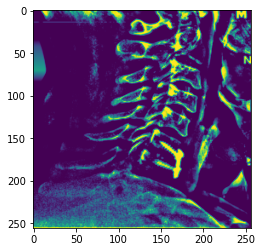

In [165]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'anterior' # or 'posterior'
img_number = 109

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()

In [166]:
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
elif dataset == 'posterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))

Output Logits: tensor([[ 0.0231, -0.1292,  1.0720, -0.8588]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[0.1950, 0.1675, 0.5567, 0.0807]], grad_fn=<SoftmaxBackward>)
Output Label: tensor(2)


In [169]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed, target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[2]]) ( 0.27153125405311584 )
True Label:  tensor(2)


torch.Size([3, 1, 256, 256])


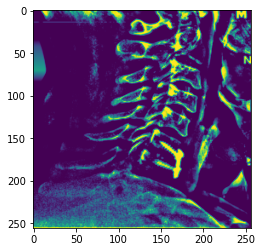

In [170]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())


### Gradient-based attribution

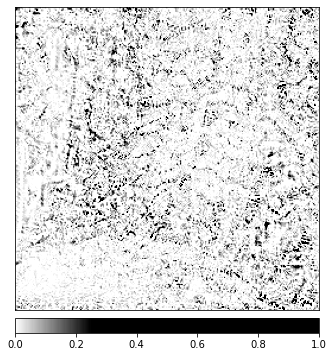

In [171]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


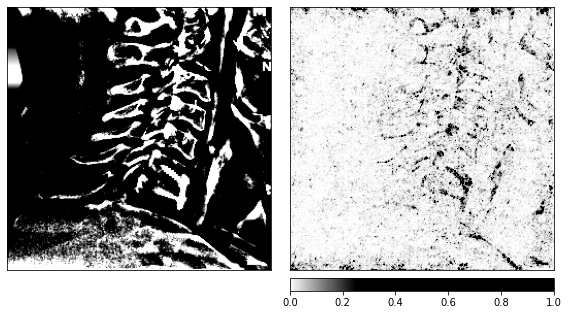

In [172]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


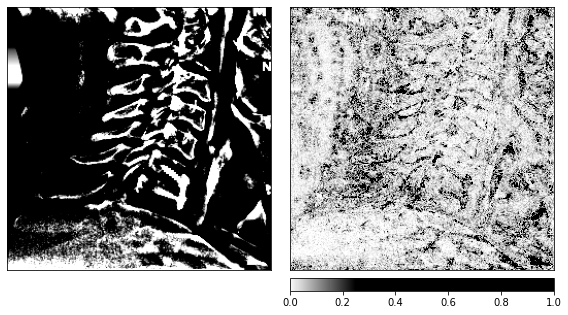

In [173]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


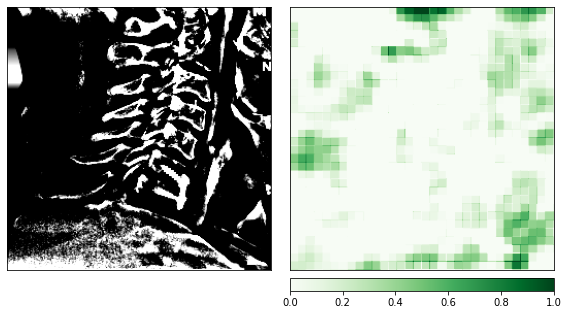

In [174]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


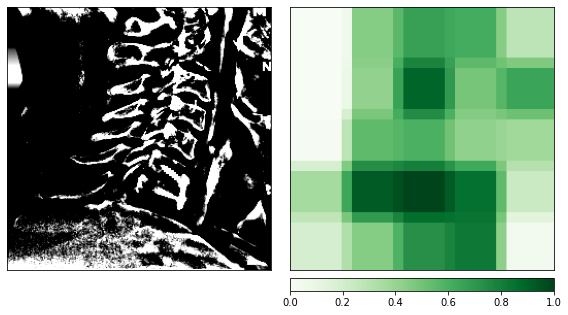

In [175]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## ANTERIOR - HELIX_ZEVO BRAND 3 (True Positive)

## ANTERIOR - ARCHON BRAND 1 (False Negative)

Label: tensor(1)


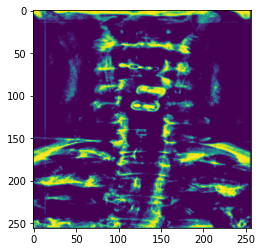

In [44]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'anterior' # or 'posterior'
img_number = 187

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()

In [45]:
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
elif dataset == 'posterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))

Output Logits: tensor([[ 0.4580, -0.4982,  0.6748, -0.5412]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[0.3339, 0.1283, 0.4148, 0.1229]], grad_fn=<SoftmaxBackward>)
Output Label: tensor(2)


In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed, target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[2]]) ( 0.41478586196899414 )
True Label:  tensor(1)


torch.Size([3, 1, 256, 256])


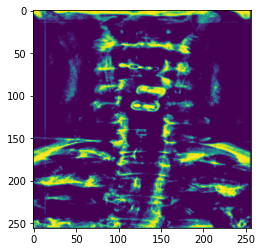

In [47]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())

### Gradient-based attribution

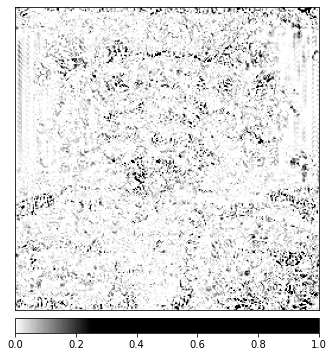

In [48]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


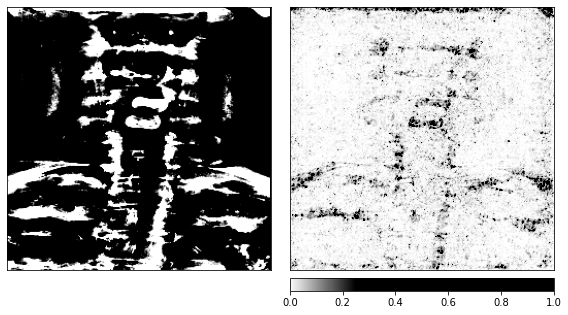

In [49]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


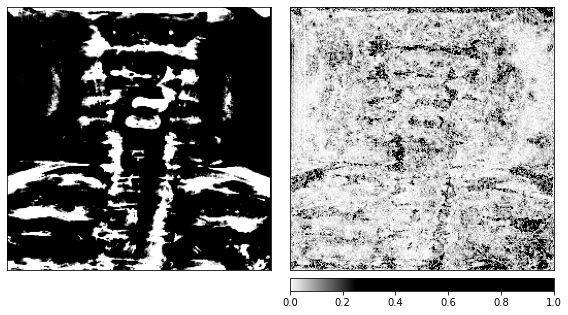

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


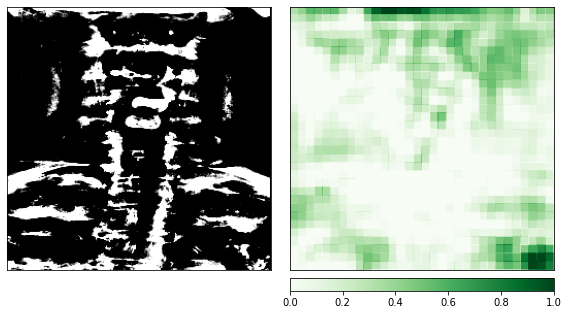

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


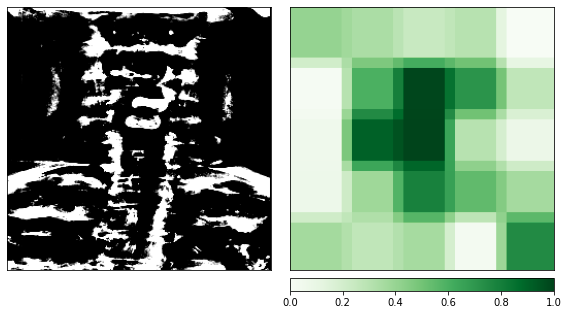

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

## POSTERIOR - MOUNTAINEER BRAND 0 (True Positive)

Label: tensor(0)


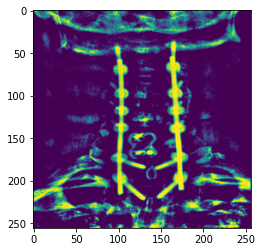

In [221]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'posterior' # or 'posterior'
img_number = 37

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()


In [224]:
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
elif dataset == 'posterior':
    data_to_feed = posterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model.to(device)
    model_ft.eval()
    output = model_ft(data_to_feed.to(device))
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))

Output Logits: tensor([[ 9.5093, -5.4888, -0.9231, -3.7776]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[9.9997e-01, 3.0648e-07, 2.9462e-05, 1.6966e-06]],
       grad_fn=<SoftmaxBackward>)
Output Label: tensor(0)


In [225]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed, target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[0]]) ( 0.9999685287475586 )
True Label:  tensor(0)


torch.Size([3, 1, 256, 256])


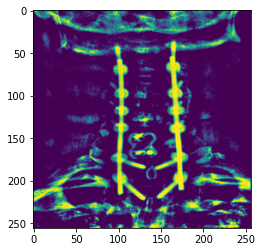

In [226]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())

### Gradient-based attribution

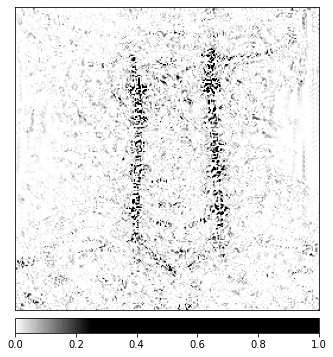

In [227]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


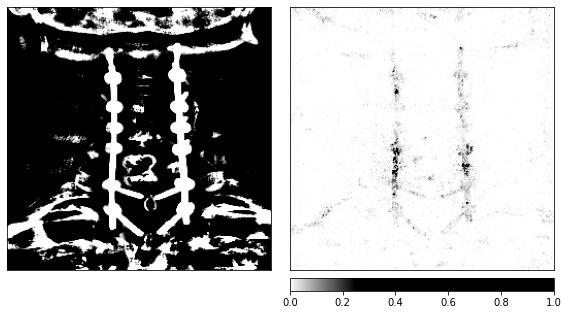

In [228]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


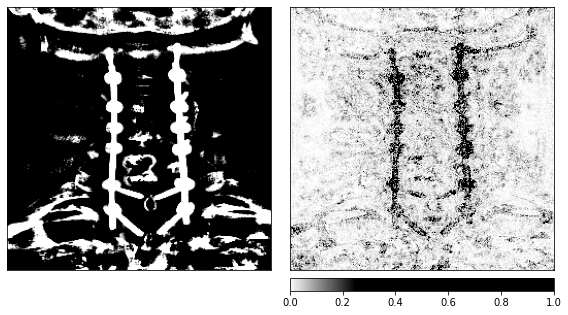

In [229]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


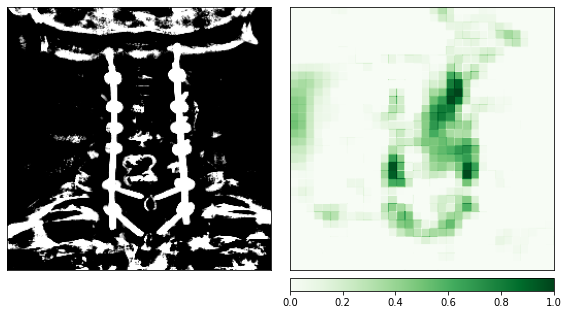

In [230]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


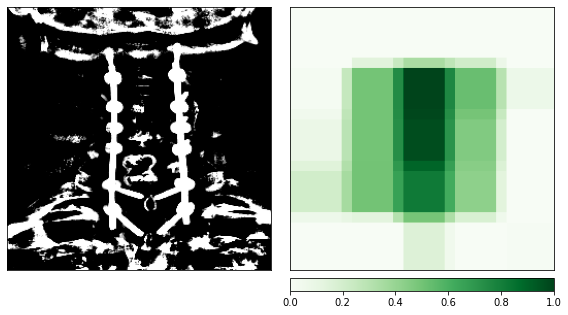

In [231]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## POSTERIOR - ARCH BRAND 1 (True Positive)

Label: tensor(1)


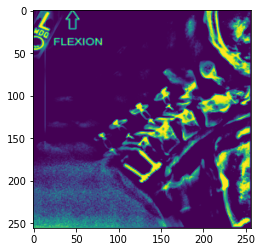

In [232]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'posterior' # or 'posterior'
img_number = 44

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()

In [235]:
device='cpu'
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
elif dataset == 'posterior':
    data_to_feed = posterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model.to(device)
    model_ft.eval()
    output = model_ft(data_to_feed.to(device))
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))

Output Logits: tensor([[-2.4608,  7.1511,  0.9106, -0.2156]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[6.6752e-05, 9.9736e-01, 1.9438e-03, 6.3034e-04]],
       grad_fn=<SoftmaxBackward>)
Output Label: tensor(1)


In [236]:
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed.to(device), target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[1]]) ( 0.9973590970039368 )
True Label:  tensor(1)


torch.Size([3, 1, 256, 256])


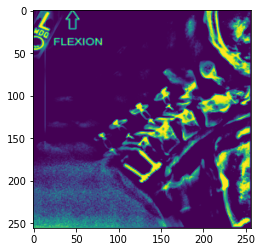

In [237]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())

### Gradient-based attributionm

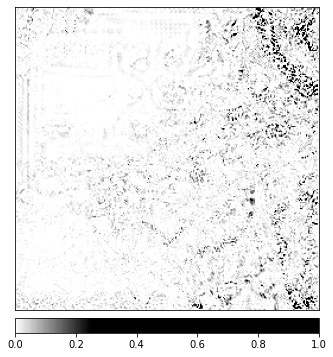

In [238]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


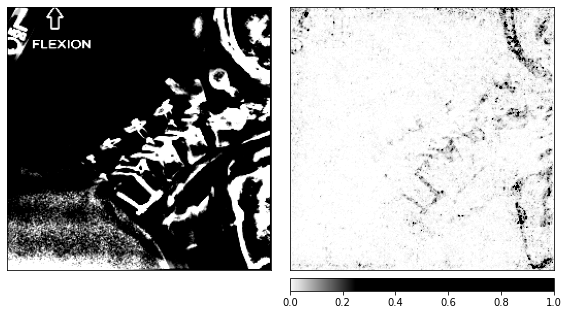

In [239]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


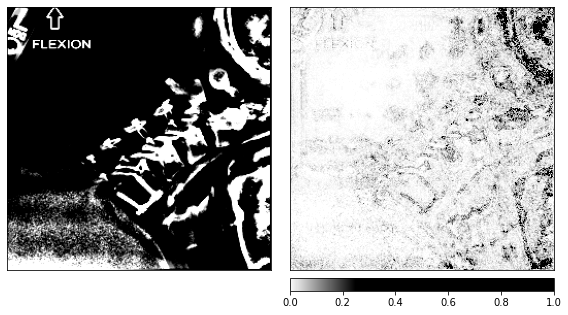

In [240]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


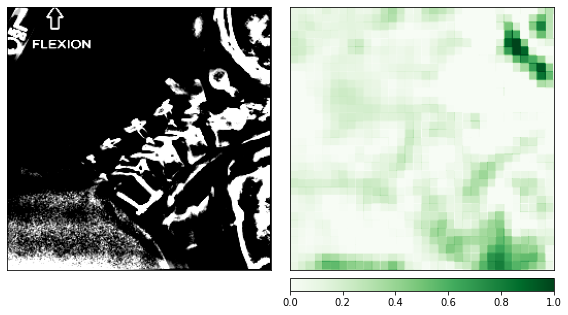

In [241]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


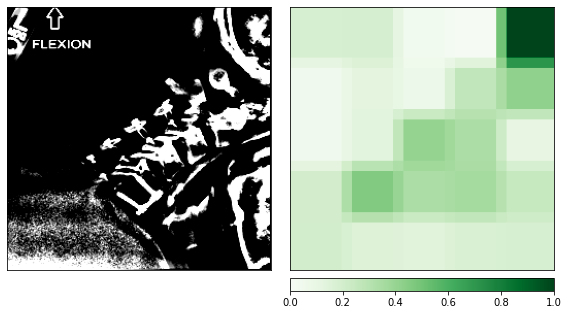

In [242]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## POSTERIOR - Vertex BRAND 2 (True Positive)

Label: tensor(2)


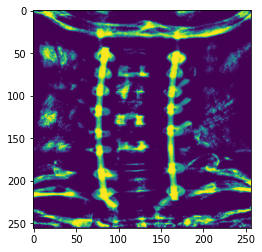

In [245]:
# HERE YOU CAN SELECT A ROW NUMBER
dataset = 'posterior' # or 'posterior'
img_number = 5

if dataset == 'anterior':
    img = anterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = anterior_dataset.__getitem__(img_number)[1]
elif dataset == 'posterior':
    img = posterior_dataset.__getitem__(img_number)[0][3:,:256,:256][0]
    label = posterior_dataset.__getitem__(img_number)[1]
print("Label:", label)
plt.imshow(img)
plt.show()

In [246]:
if dataset == 'anterior':
    data_to_feed = anterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #anterior_model.eval()
    model_ft = anterior_model
    model_ft.eval()
    output = model_ft(data_to_feed)
elif dataset == 'posterior':
    data_to_feed = posterior_dataset.__getitem__(img_number)[0].unsqueeze(0)
    #posterior_model.eval()
    model_ft = posterior_model.to(device)
    model_ft.eval()
    output = model_ft(data_to_feed.to(device))
    #output = posterior_model(data_to_feed)
print("Output Logits:", output)
print("Output Probabilities:", nn.Softmax(dim=-1)(output))
print("Output Label:", torch.argmax(nn.Softmax(dim=-1)(output)))


Output Logits: tensor([[ 0.6961,  0.8964,  2.2069, -0.5484]], grad_fn=<AddmmBackward>)
Output Probabilities: tensor([[0.1420, 0.1735, 0.6435, 0.0409]], grad_fn=<SoftmaxBackward>)
Output Label: tensor(2)


In [247]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
y_val = output
output = F.softmax(y_val, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
print('Predicted:', pred_label_idx, '(', prediction_score.squeeze().item(), ')')
print('True Label: ', label)

integrated_gradients = IntegratedGradients(model_ft)
attributions_ig = integrated_gradients.attribute(data_to_feed, target=pred_label_idx.to(device), n_steps=200)

Predicted: tensor([[2]]) ( 0.6434923410415649 )
True Label:  tensor(2)


torch.Size([3, 1, 256, 256])


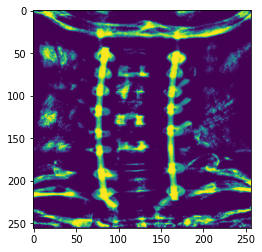

In [248]:
img.shape
transformed_img = img
transformed_img= transformed_img.view(1, 256,256)
transformed_img= torch.stack([transformed_img, transformed_img, transformed_img], dim=0)
print(transformed_img.shape)
transformed_img = transformed_img.view(1,3,256,256)
# plotting image
plt.imshow(transformed_img.view(3,256,256)[0].to('cpu').numpy())

### Gradient-based attribution

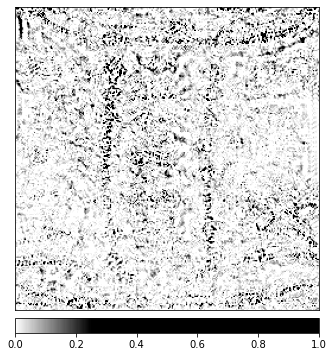

In [249]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


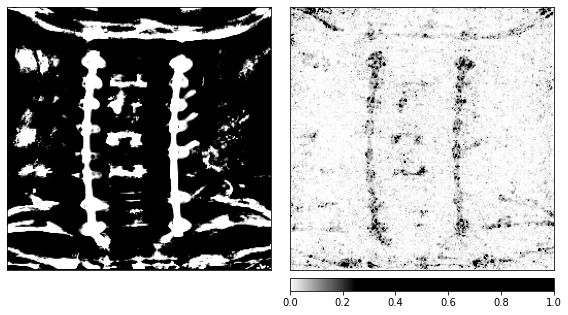

In [250]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
device='cpu'
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
integrated_gradients = IntegratedGradients(model_ft.to(device))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(data_to_feed.to(device), n_samples=3, nt_type='smoothgrad_sq', target=pred_label_idx.to(device))

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


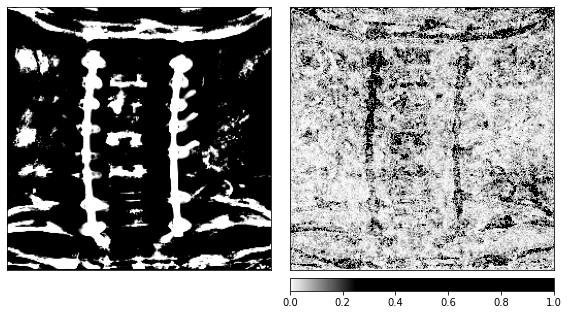

In [251]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(0)
device='cpu'
gradient_shap = GradientShap(model_ft.to(device))

# Defining baseline distribution of images
rand_img_dist = torch.cat([data_to_feed * 0, data_to_feed * 1])

attributions_gs = gradient_shap.attribute(data_to_feed.to(device),
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx.to(device))
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

### Occlusion-based attribution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


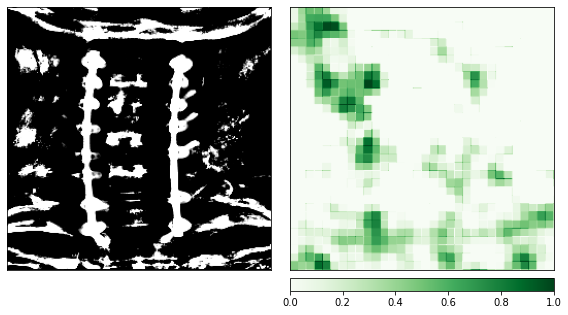

In [253]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 8, 8),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


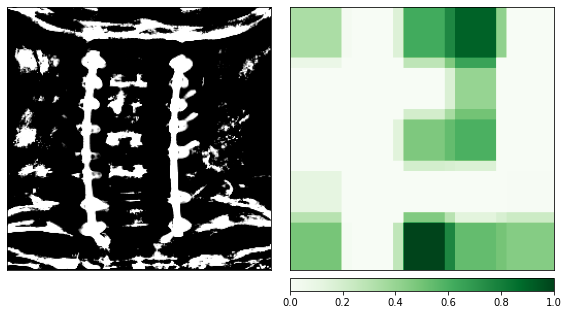

In [254]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
occlusion = Occlusion(model_ft.to(device))

attributions_occ = occlusion.attribute(data_to_feed.to(device),
                                       strides = (3, 50, 50),
                                       target=pred_label_idx.to(device),
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.to(device).squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

**----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**